Rodrigo Burgos F 2019230505-6
Luis Fuentes M 201923012-3

Reocrdar ejecutar como administrador

3.a

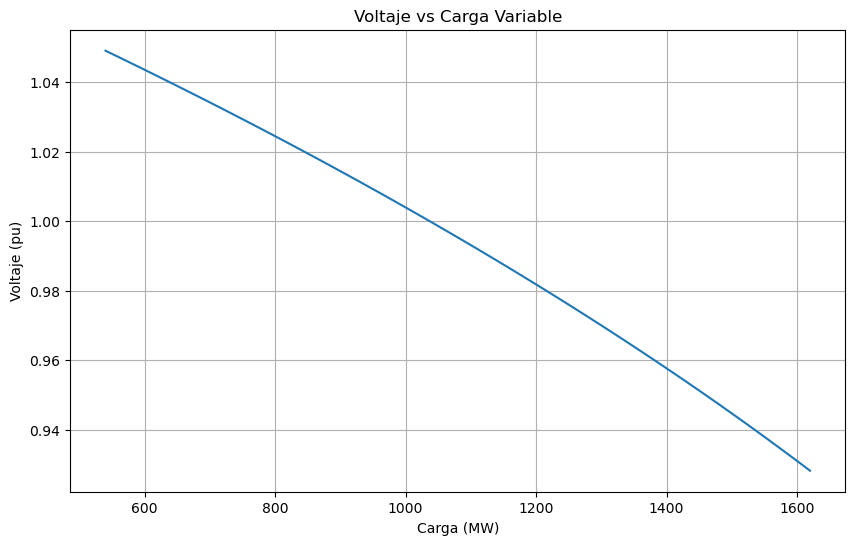

In [1]:
import pandapower as pp
import pandapower.networks as pn
import pandapower.plotting as plot
import matplotlib.pyplot as plt
import numpy as np

# Crear la red de pandapower
net = pp.create_empty_network()

# Definir las constantes
V_base = 500e3  # 500 kV
S_base = 1200e6  # 1200 MVA
P_load = S_base * 0.9  # Carga a FP 0.9
cos_phi = 0.9
sin_phi = np.sqrt(1 - cos_phi**2)
Q_load = P_load * sin_phi / cos_phi  # Calcular Q de la carga

# Crear barras
bus1 = pp.create_bus(net, vn_kv=500)
bus2 = pp.create_bus(net, vn_kv=500)

# Agregar un ext_grid en bus1 como barra de referencia
pp.create_ext_grid(net, bus1, vm_pu=1.0, name="Ext Grid")

# Crear línea de transmisión
pp.create_line_from_parameters(net, from_bus=bus1, to_bus=bus2, length_km=500, r_ohm_per_km=0.02, x_ohm_per_km=0.115, c_nf_per_km=19.1, max_i_ka=1)
pp.create_line_from_parameters(net, from_bus=bus1, to_bus=bus2, length_km=500, r_ohm_per_km=0.02, x_ohm_per_km=0.115, c_nf_per_km=19.1, max_i_ka=1)

# Crear carga en bus2
load = pp.create_load(net, bus2, p_mw=P_load/1e6, q_mvar=Q_load/1e6, name="Load")

# Crear listas para almacenar los resultados
voltages = []
loads = []

# Variar la carga en el rango ±50%
for factor in np.linspace(0.5, 1.5, 100):
    net.load.at[load, 'p_mw'] = (P_load * factor) / 1e6
    net.load.at[load, 'q_mvar'] = (Q_load * factor) / 1e6
    pp.runpp(net)
    voltages.append(net.res_bus.vm_pu[bus2])
    loads.append(P_load * factor / 1e6)

# Graficar el resultado
plt.figure(figsize=(10, 6))
plt.plot(loads, voltages)
plt.xlabel('Carga (MW)')
plt.ylabel('Voltaje (pu)')
plt.title('Voltaje vs Carga Variable')
plt.grid(True)
plt.show()

3.b

In [30]:
import pandapower as pp
import pandapower.networks as pn
import pandapower.plotting as plot
import matplotlib.pyplot as plt
import numpy as np

# Crear la red de pandapower
net = pp.create_empty_network()

# Definir las constantes
V_base = 500e3  # 500 kV
S_base = 1200e6  # 1200 MVA
P_load = S_base * 0.9  # Carga a FP 0.9
cos_phi = 0.9
sin_phi = np.sqrt(1 - cos_phi**2)
Q_load = P_load * sin_phi / cos_phi  # Calcular Q de la carga

# Crear barras
bus1 = pp.create_bus(net, vn_kv=500)
bus2 = pp.create_bus(net, vn_kv=500)

# Agregar un ext_grid en bus1 como barra de referencia
pp.create_ext_grid(net, bus1, vm_pu=1.0, name="Ext Grid")

# Crear línea de transmisión
pp.create_line_from_parameters(net, from_bus=bus1, to_bus=bus2, length_km=500, r_ohm_per_km=0.02, x_ohm_per_km=0.115, c_nf_per_km=19.1, max_i_ka=1)
pp.create_line_from_parameters(net, from_bus=bus1, to_bus=bus2, length_km=500, r_ohm_per_km=0.02, x_ohm_per_km=0.115, c_nf_per_km=19.1, max_i_ka=1)

# Crear carga en bus2
load = pp.create_load(net, bus2, p_mw=P_load/1e6, q_mvar=Q_load/1e6, name="Load")

# Crear vectores para almacenar los resultados
num_samples = 100
voltages = np.zeros(num_samples)
loads = np.zeros(num_samples)
compensations = np.zeros(num_samples)

# Función para calcular la compensación shunt necesaria
def calculate_shunt_compensation(net, bus, target_vmin, target_vmax):
    shunt_q_mvar = 0
    step_q_mvar = 1  # paso de 1 MVAR
    while True:
        pp.create_sgen(net, bus, p_mw=0, q_mvar=shunt_q_mvar, name="Shunt")
        pp.runpp(net)
        voltage = net.res_bus.vm_pu[bus]
        net.sgen.drop(net.sgen[net.sgen['name'] == 'Shunt'].index, inplace=True)
        if target_vmin <= voltage <= target_vmax:
            break
        shunt_q_mvar += step_q_mvar
        if shunt_q_mvar > 1000:  # Limite razonable de 1000 MVAR para evitar bucles infinitos
            break
    return shunt_q_mvar

# Variar la carga en el rango ±50%
for i, factor in enumerate(np.linspace(0.5, 1.5, num_samples)):
    net.load.at[load, 'p_mw'] = (P_load * factor) / 1e6
    net.load.at[load, 'q_mvar'] = (Q_load * factor) / 1e6
    shunt_q_mvar = calculate_shunt_compensation(net, bus2, 0.95, 1.05)
    pp.create_sgen(net, bus2, p_mw=0, q_mvar=shunt_q_mvar, name="Shunt")
    pp.runpp(net)
    voltages[i] = net.res_bus.vm_pu[bus2]
    loads[i] = P_load * factor / 1e6
    compensations[i] = shunt_q_mvar
    net.sgen.drop(net.sgen[net.sgen['name'] == 'Shunt'].index, inplace=True)



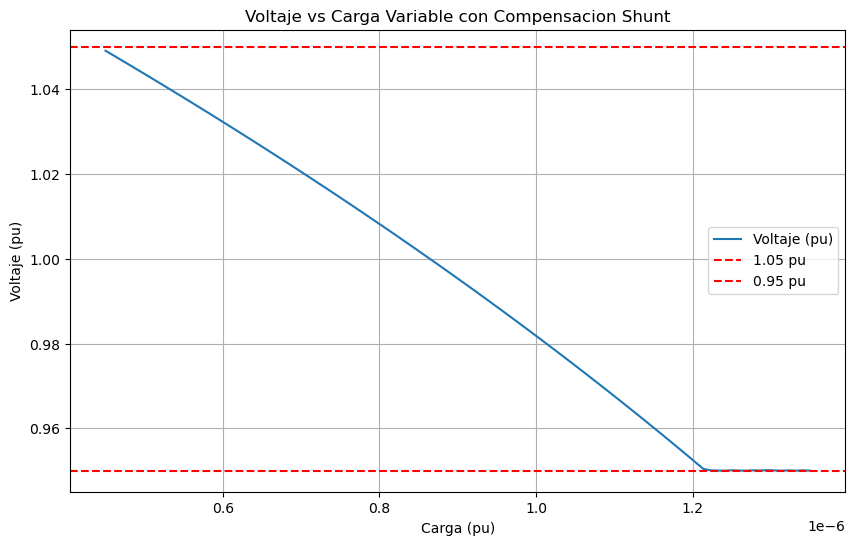

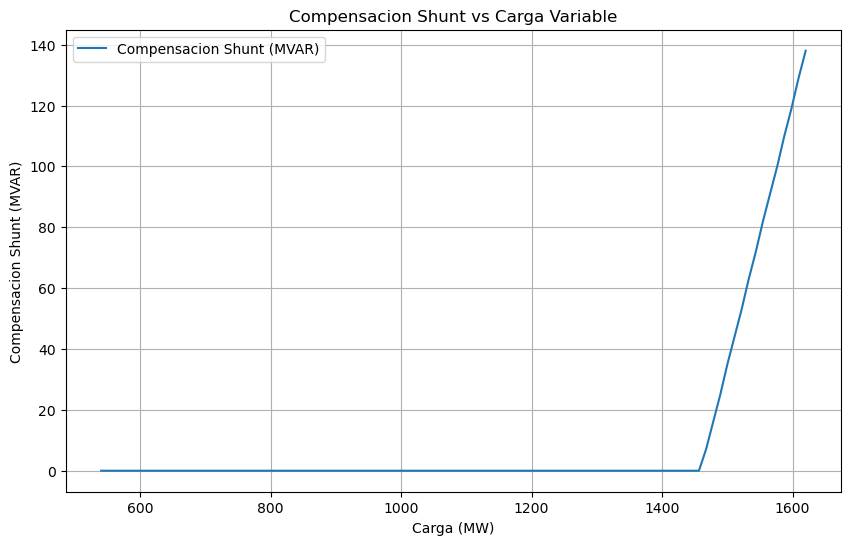

In [32]:
# Graficar el resultado
plt.figure(figsize=(10, 6))
plt.plot(loads/S_base, voltages, label='Voltaje (pu)')
plt.axhline(y=1.05, color='r', linestyle='--', label='1.05 pu')
plt.axhline(y=0.95, color='r', linestyle='--', label='0.95 pu')
plt.xlabel('Carga (pu)')
plt.ylabel('Voltaje (pu)')
plt.title('Voltaje vs Carga Variable con Compensacion Shunt')
plt.legend()
plt.grid(True)

# Graficar la compensación shunt necesaria
plt.figure(figsize=(10, 6))
plt.plot(loads, compensations, label='Compensacion Shunt (MVAR)')
plt.xlabel('Carga (MW)')
plt.ylabel('Compensacion Shunt (MVAR)')
plt.title('Compensacion Shunt vs Carga Variable')
plt.legend()
plt.grid(True)

plt.show()

3.c

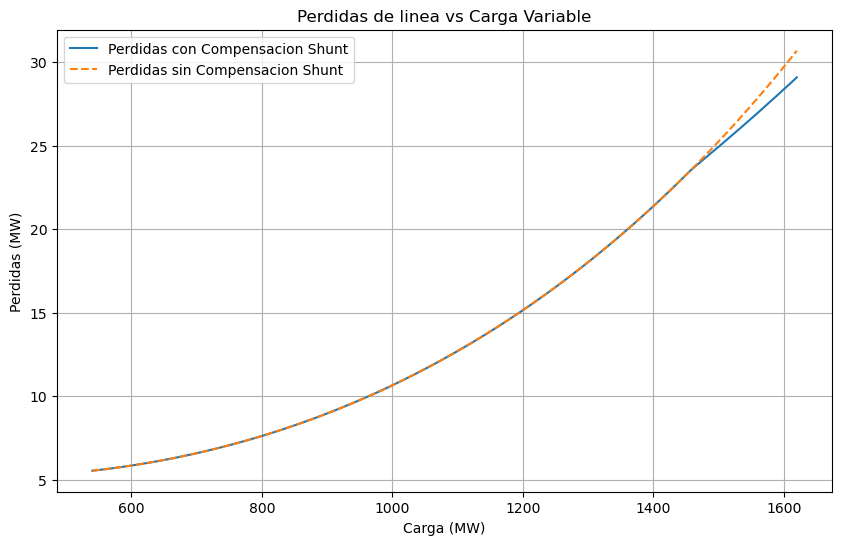

In [7]:
import pandapower as pp
import pandapower.networks as pn
import pandapower.plotting as plot
import matplotlib.pyplot as plt
import numpy as np

# Crear la red de pandapower
net = pp.create_empty_network()

# Definir las constantes
V_base = 500e3  # 500 kV
S_base = 1200e6  # 1200 MVA
P_load = S_base * 0.9  # Carga a FP 0.9
cos_phi = 0.9
sin_phi = np.sqrt(1 - cos_phi**2)
Q_load = P_load * sin_phi / cos_phi  # Calcular Q de la carga

# Crear barras
bus1 = pp.create_bus(net, vn_kv=500)
bus2 = pp.create_bus(net, vn_kv=500)

# Agregar un ext_grid en bus1 como barra de referencia
pp.create_ext_grid(net, bus1, vm_pu=1.0, name="Ext Grid")

# Crear línea de transmisión
line = pp.create_line_from_parameters(net, from_bus=bus1, to_bus=bus2, length_km=500, r_ohm_per_km=0.02, x_ohm_per_km=0.115, c_nf_per_km=19.1, max_i_ka=1)
line = pp.create_line_from_parameters(net, from_bus=bus1, to_bus=bus2, length_km=500, r_ohm_per_km=0.02, x_ohm_per_km=0.115, c_nf_per_km=19.1, max_i_ka=1)

# Crear carga en bus2
load = pp.create_load(net, bus2, p_mw=P_load/1e6, q_mvar=Q_load/1e6, name="Load")

# Función para calcular la compensación shunt necesaria
def calculate_shunt_compensation(net, bus, target_vmin, target_vmax):
    shunt_q_mvar = 0
    step_q_mvar = 1  # paso de 1 MVAR
    while True:
        pp.create_sgen(net, bus, p_mw=0, q_mvar=shunt_q_mvar, name="Shunt")
        pp.runpp(net)
        voltage = net.res_bus.vm_pu[bus]
        net.sgen.drop(net.sgen[net.sgen['name'] == 'Shunt'].index, inplace=True)
        if target_vmin <= voltage <= target_vmax:
            break
        shunt_q_mvar += step_q_mvar
        if shunt_q_mvar > 1000:  # Limite razonable de 1000 MVAR para evitar bucles infinitos
            break
    return shunt_q_mvar

# Crear listas para almacenar los resultados
loads = []
losses_with_comp = []
losses_without_comp = []

# Variar la carga en el rango ±50%
for factor in np.linspace(0.5, 1.5, 100):
    net.load.at[load, 'p_mw'] = (P_load * factor) / 1e6
    net.load.at[load, 'q_mvar'] = (Q_load * factor) / 1e6
    
    # Calcular pérdidas sin compensación
    pp.runpp(net)
    losses_without_comp.append(net.res_line.pl_mw[line])
    
    # Calcular pérdidas con compensación
    shunt_q_mvar = calculate_shunt_compensation(net, bus2, 0.95, 1.05)
    pp.create_sgen(net, bus2, p_mw=0, q_mvar=shunt_q_mvar, name="Shunt")
    pp.runpp(net)
    losses_with_comp.append(net.res_line.pl_mw[line])
    
    # Almacenar el valor de la carga
    loads.append(P_load * factor / 1e6)
    
    # Eliminar la compensación shunt para la próxima iteración
    net.sgen.drop(net.sgen[net.sgen['name'] == 'Shunt'].index, inplace=True)

# Graficar el resultado
plt.figure(figsize=(10, 6))
plt.plot(loads, losses_with_comp, label='Perdidas con Compensacion Shunt')
plt.plot(loads, losses_without_comp, label='Perdidas sin Compensacion Shunt', linestyle='--')
plt.xlabel('Carga (MW)')
plt.ylabel('Perdidas (MW)')
plt.title('Perdidas de linea vs Carga Variable')
plt.legend()
plt.grid(True)
plt.show()


4.a

In [16]:
import pandapower as pp
import pandapower.plotting as plot
import matplotlib.pyplot as plt

# Crear una red vacía
net = pp.create_empty_network()

# Crear barras
b1 = pp.create_bus(net, vn_kv=110, name="Bus 1")  # Barra 1
b2 = pp.create_bus(net, vn_kv=220, name="Bus 2")  # Barra 2
b1a = pp.create_bus(net, vn_kv=220, name="Bus 1A")  # Barra 1A
b2a = pp.create_bus(net, vn_kv=220, name="Bus 2A")  # Barra 2A
b3a = pp.create_bus(net, vn_kv=220, name="Bus 3A")  # Barra 3A
b2b = pp.create_bus(net, vn_kv=220, name="Bus 2B")  # Barra 2B
b1b = pp.create_bus(net, vn_kv=220, name="Bus 1B")  # Barra 1B

# Añadir generadores
pp.create_gen(net, b1, p_mw=1, slack=True, name="Generator")

# Añadir transformadores
pp.create_transformer(net, b2, b1, std_type="100 MVA 220/110 kV")

# Definir el tipo de línea
line_type = 'N2XS(FL)2Y 1x185 RM/35 64/110 kV'

# Añadir líneas
linea_1a = pp.create_line(net, b2, b1a, length_km=10, std_type=line_type, name="Linea 1A")
linea_1b = pp.create_line(net, b2, b1b, length_km=10, std_type=line_type, name="Linea 1B")
linea_2a = pp.create_line(net, b1a, b2a, length_km=15, std_type=line_type, name="Linea 2A")
linea_3a = pp.create_line(net, b2a, b3a, length_km=20, std_type=line_type, name="Linea 3A")
linea_4a = pp.create_line(net, b3a, b2b, length_km=15, std_type=line_type, name="Linea AB")
linea_2b = pp.create_line(net, b1b, b2b, length_km=30, std_type=line_type, name="Linea 2B")

# Añadir cargas
pp.create_load(net, b1a, p_mw=150*0.20, q_mvar=100*0.20, name="Load 1A")
pp.create_load(net, b2a, p_mw=150*0.35, q_mvar=100*0.35, name="Load 2A")
pp.create_load(net, b3a, p_mw=150*0.15, q_mvar=100*0.15, name="Load 3A")
pp.create_load(net, b2b, p_mw=150*0.60, q_mvar=100*0.60, name="Load 4A")
pp.create_load(net, b1b, p_mw=150*0.10, q_mvar=100*0.10, name="Load 1B")

# Realizar el flujo de carga
pp.runpp(net)

# Resultados de flujo de carga
line_loading = net.res_line.loading_percent
for idx, load in enumerate(line_loading):
    print(f"{net.line.loc[idx, 'name']} Porcentaje de Carga: {load:.2f}%")


plt.show()


Linea 1A Porcentaje de Carga: 66.09%
Linea 1B Porcentaje de Carga: 56.39%
Linea 2A Porcentaje de Carga: 49.79%
Linea 3A Porcentaje de Carga: 24.36%
Linea AB Porcentaje de Carga: 16.69%
Linea 2B Porcentaje de Carga: 47.57%


4.b

In [56]:

import pandapower as pp

# Crear una red vacía
net = pp.create_empty_network()

# Crear barras
b1 = pp.create_bus(net, vn_kv=110, name="Bus 1")  # Barra 1
b2 = pp.create_bus(net, vn_kv=220, name="Bus 2")  # Barra 2
b1a = pp.create_bus(net, vn_kv=220, name="Bus 1A")  # Barra 1A
b2a = pp.create_bus(net, vn_kv=220, name="Bus 2A")  # Barra 2A
b3a = pp.create_bus(net, vn_kv=220, name="Bus 3A")  # Barra 3A
b2b = pp.create_bus(net, vn_kv=220, name="Bus 2B")  # Barra 2B
b1b = pp.create_bus(net, vn_kv=220, name="Bus 1B")  # Barra 1B

# Añadir generadores
pp.create_gen(net, b1, p_mw=1, slack=True, name="Generator")

# Añadir transformadores
pp.create_transformer(net, b2, b1, std_type="100 MVA 220/110 kV")

# Definir el tipo de línea
line_type = 'N2XS(FL)2Y 1x185 RM/35 64/110 kV'

# Añadir líneas
linea_1a = pp.create_line(net, b2, b1a, length_km=10, std_type=line_type, name="Linea 1A")
linea_1b = pp.create_line(net, b2, b1b, length_km=10, std_type=line_type, name="Linea 1B")
linea_2a = pp.create_line(net, b1a, b2a, length_km=15, std_type=line_type, name="Linea 2A")
linea_3a = pp.create_line(net, b2a, b3a, length_km=20, std_type=line_type, name="Linea 3A")
linea_4a = pp.create_line(net, b3a, b2b, length_km=15, std_type=line_type, name="Linea AB")
linea_2b = pp.create_line(net, b1b, b2b, length_km=30, std_type=line_type, name="Linea 2B")

# Añadir cargas
pp.create_load(net, b1a, p_mw=150*0.20, q_mvar=100*0.20, name="Load 1A")
pp.create_load(net, b2a, p_mw=150*0.35, q_mvar=100*0.35, name="Load 2A")
pp.create_load(net, b3a, p_mw=150*0.15, q_mvar=100*0.15, name="Load 3A")
pp.create_load(net, b2b, p_mw=150*0.60, q_mvar=100*0.60, name="Load 4A")
pp.create_load(net, b1b, p_mw=150*0.10, q_mvar=100*0.10, name="Load 1B")

# Realizar el flujo de carga
pp.runpp(net)

# Mostrar las tensiones de las barras en pu y evaluar el estado
print("Estado de las barras:")

for bus in net.bus.index:
    bus_name = net.bus.at[bus, "name"]
    voltage_pu = net.res_bus.at[bus, "vm_pu"]
    
    # Determinar el estado de la barra
    if abs(voltage_pu - 1.0) <= 0.05:
        estado = "Normal"
    elif abs(voltage_pu - 1.0) <= 0.07:
        estado = "Alerta"
    else:
        estado = "Fuera de rango"
    
    print(f"{bus_name}: Tensión = {voltage_pu:.4f} p.u., Estado = {estado}")



Estado de las barras:
Bus 1: Tensión = 1.0000 p.u., Estado = Normal
Bus 2: Tensión = 1.0334 p.u., Estado = Normal
Bus 1A: Tensión = 1.0315 p.u., Estado = Normal
Bus 2A: Tensión = 1.0292 p.u., Estado = Normal
Bus 3A: Tensión = 1.0284 p.u., Estado = Normal
Bus 2B: Tensión = 1.0274 p.u., Estado = Normal
Bus 1B: Tensión = 1.0324 p.u., Estado = Normal


4e

In [14]:
import pandapower as pp

# Crear una red vacía
net = pp.create_empty_network()

# Crear barras
b1 = pp.create_bus(net, vn_kv=110, name="Bus 1")  # Barra 1
b2 = pp.create_bus(net, vn_kv=220, name="Bus 2")  # Barra 2
b1a = pp.create_bus(net, vn_kv=220, name="Bus 1A")  # Barra 1A
b2a = pp.create_bus(net, vn_kv=220, name="Bus 2A")  # Barra 2A
b3a = pp.create_bus(net, vn_kv=220, name="Bus 3A")  # Barra 3A
b2b = pp.create_bus(net, vn_kv=220, name="Bus 2B")  # Barra 2B
b1b = pp.create_bus(net, vn_kv=220, name="Bus 1B")  # Barra 1B

# Añadir generadores
pp.create_gen(net, b1, p_mw=1, slack=True, name="Generator")

# Añadir transformadores
pp.create_transformer(net, b2, b1, std_type="100 MVA 220/110 kV")

# Definir el tipo de línea
line_type = 'N2XS(FL)2Y 1x185 RM/35 64/110 kV'

# Añadir líneas
linea_1a = pp.create_line(net, b2, b1a, length_km=10, std_type=line_type, name="Linea 1A")
linea_1b = pp.create_line(net, b2, b1b, length_km=10, std_type=line_type, name="Linea 1B")
linea_2a = pp.create_line(net, b1a, b2a, length_km=15, std_type=line_type, name="Linea 2A")
linea_3a = pp.create_line(net, b2a, b3a, length_km=20, std_type=line_type, name="Linea 3A")
linea_4a = pp.create_line(net, b3a, b2b, length_km=15, std_type=line_type, name="Linea AB")
linea_2b = pp.create_line(net, b1b, b2b, length_km=30, std_type=line_type, name="Linea 2B")

# Añadir cargas
pp.create_load(net, b1a, p_mw=150*0.20, q_mvar=100*0.20, name="Load 1A")
pp.create_load(net, b2a, p_mw=150*0.35, q_mvar=100*0.35, name="Load 2A")
pp.create_load(net, b3a, p_mw=150*0.15, q_mvar=100*0.15, name="Load 3A")
pp.create_load(net, b2b, p_mw=150*0.60, q_mvar=100*0.60, name="Load 4A")
pp.create_load(net, b1b, p_mw=150*0.10, q_mvar=100*0.10, name="Load 1B")

# Realizar el flujo de carga inicial
pp.runpp(net)

# Mostrar las tensiones de las barras en pu y evaluar el estado antes del cambio
print("Estado de las barras:")
for bus in net.bus.index:
    bus_name = net.bus.at[bus, "name"]
    voltage_pu = net.res_bus.at[bus, "vm_pu"]
    
    # Determinar el estado de la barra antes del cambio
    if abs(voltage_pu - 1.0) <= 0.05:
        estado = "Normal"
    elif abs(voltage_pu - 1.0) <= 0.07:
        estado = "Alerta"
    else:
        estado = "Fuera de rango"
    
    print(f"{bus_name}: Tensión = {voltage_pu:.4f} p.u., Estado = {estado}")

# Mostrar la carga de las líneas antes del cambio
print("\nCarga de las líneas:")
for line in net.line.index:
    line_name = net.line.at[line, "name"]
    loading_percent = net.res_line.at[line, "loading_percent"]
    print(f"{line_name}: Porcentaje de Carga = {loading_percent:.2f}%")


    

Estado de las barras:
Bus 1: Tensión = 1.0000 p.u., Estado = Normal
Bus 2: Tensión = 1.0334 p.u., Estado = Normal
Bus 1A: Tensión = 1.0315 p.u., Estado = Normal
Bus 2A: Tensión = 1.0292 p.u., Estado = Normal
Bus 3A: Tensión = 1.0284 p.u., Estado = Normal
Bus 2B: Tensión = 1.0274 p.u., Estado = Normal
Bus 1B: Tensión = 1.0324 p.u., Estado = Normal

Carga de las líneas:
Linea 1A: Porcentaje de Carga = 66.09%
Linea 1B: Porcentaje de Carga = 56.39%
Linea 2A: Porcentaje de Carga = 49.79%
Linea 3A: Porcentaje de Carga = 24.36%
Linea AB: Porcentaje de Carga = 16.69%
Linea 2B: Porcentaje de Carga = 47.57%


In [12]:
import pandapower as pp

# Crear una red vacía
net = pp.create_empty_network()

# Crear barras
b1 = pp.create_bus(net, vn_kv=110, name="Bus 1")  # Barra 1
b2 = pp.create_bus(net, vn_kv=220, name="Bus 2")  # Barra 2
b1a = pp.create_bus(net, vn_kv=220, name="Bus 1A")  # Barra 1A
b2a = pp.create_bus(net, vn_kv=220, name="Bus 2A")  # Barra 2A
b3a = pp.create_bus(net, vn_kv=220, name="Bus 3A")  # Barra 3A
b2b = pp.create_bus(net, vn_kv=220, name="Bus 2B")  # Barra 2B
b1b = pp.create_bus(net, vn_kv=220, name="Bus 1B")  # Barra 1B

# Añadir generadores
pp.create_gen(net, b1, p_mw=1, slack=True, name="Generator")

# Añadir transformadores
pp.create_transformer(net, b2, b1, std_type="100 MVA 220/110 kV")

# Definir el tipo de línea
line_type = 'N2XS(FL)2Y 1x185 RM/35 64/110 kV'

# Añadir líneas
linea_1a = pp.create_line(net, b2, b1a, length_km=10, std_type=line_type, name="Linea 1A")
linea_1b = pp.create_line(net, b2, b1b, length_km=10, std_type=line_type, name="Linea 1B")
linea_2a = pp.create_line(net, b1a, b2a, length_km=15, std_type=line_type, name="Linea 2A")
linea_3a = pp.create_line(net, b2a, b3a, length_km=20, std_type=line_type, name="Linea 3A")

linea_2b = pp.create_line(net, b1b, b2b, length_km=30, std_type=line_type, name="Linea 2B")

# Añadir cargas
pp.create_load(net, b1a, p_mw=150*0.20, q_mvar=100*0.20, name="Load 1A")
pp.create_load(net, b2a, p_mw=150*0.35, q_mvar=100*0.35, name="Load 2A")
pp.create_load(net, b3a, p_mw=150*0.15, q_mvar=100*0.15, name="Load 3A")
pp.create_load(net, b2b, p_mw=150*0.60, q_mvar=100*0.60, name="Load 4A")
pp.create_load(net, b1b, p_mw=150*0.10, q_mvar=100*0.10, name="Load 1B")

# Realizar el flujo de carga inicial
pp.runpp(net)

# Mostrar las tensiones de las barras en pu y evaluar el estado antes del cambio
print("Estado de las barras al desconectar la línea 3A-2B:")
for bus in net.bus.index:
    bus_name = net.bus.at[bus, "name"]
    voltage_pu = net.res_bus.at[bus, "vm_pu"]
    
    # Determinar el estado de la barra antes del cambio
    if abs(voltage_pu - 1.0) <= 0.05:
        estado = "Normal"
    elif abs(voltage_pu - 1.0) <= 0.07:
        estado = "Alerta"
    else:
        estado = "Fuera de rango"
    
    print(f"{bus_name}: Tensión = {voltage_pu:.4f} p.u., Estado = {estado}")

# Mostrar la carga de las líneas antes del cambio
print("\nCarga de las líneas al desconectar la línea 3A-2B:")
for line in net.line.index:
    line_name = net.line.at[line, "name"]
    loading_percent = net.res_line.at[line, "loading_percent"]
    print(f"{line_name}: Porcentaje de Carga = {loading_percent:.2f}%")



#


Estado de las barras al desconectar la línea 3A-2B:
Bus 1: Tensión = 1.0000 p.u., Estado = Normal
Bus 2: Tensión = 0.9700 p.u., Estado = Normal
Bus 1A: Tensión = 0.9678 p.u., Estado = Normal
Bus 2A: Tensión = 0.9654 p.u., Estado = Normal
Bus 3A: Tensión = 0.9646 p.u., Estado = Normal
Bus 2B: Tensión = 0.9583 p.u., Estado = Normal
Bus 1B: Tensión = 0.9675 p.u., Estado = Normal

Carga de las líneas al desconectar la línea 3A-2B:
Linea 1A: Porcentaje de Carga = 62.66%
Linea 1B: Porcentaje de Carga = 63.60%
Linea 2A: Porcentaje de Carga = 45.47%
Linea 3A: Porcentaje de Carga = 18.06%
Linea 2B: Porcentaje de Carga = 64.82%


4f

In [2]:
import pandapower as pp

# Crear una red vacía
net = pp.create_empty_network()

# Crear barras
b1 = pp.create_bus(net, vn_kv=110, name="Bus 1")  # Barra 1
b2 = pp.create_bus(net, vn_kv=220, name="Bus 2")  # Barra 2
b1a = pp.create_bus(net, vn_kv=220, name="Bus 1A")  # Barra 1A
b2a = pp.create_bus(net, vn_kv=220, name="Bus 2A")  # Barra 2A
b3a = pp.create_bus(net, vn_kv=220, name="Bus 3A")  # Barra 3A
b2b = pp.create_bus(net, vn_kv=220, name="Bus 2B")  # Barra 2B
b1b = pp.create_bus(net, vn_kv=220, name="Bus 1B")  # Barra 1B

# Añadir generadores
pp.create_gen(net, b1, p_mw=1, slack=True, name="Generator")

# Añadir transformadores
pp.create_transformer(net, b2, b1, std_type="100 MVA 220/110 kV")

# Definir el tipo de línea
line_type = 'N2XS(FL)2Y 1x185 RM/35 64/110 kV'

# Añadir líneas
linea_1a = pp.create_line(net, b2, b1a, length_km=10, std_type=line_type, name="Linea 1A")
linea_1b = pp.create_line(net, b2, b1b, length_km=10, std_type=line_type, name="Linea 1B")
linea_2a = pp.create_line(net, b1a, b2a, length_km=15, std_type=line_type, name="Linea 2A")
linea_3a = pp.create_line(net, b2a, b3a, length_km=20, std_type=line_type, name="Linea 3A")
linea_4a = pp.create_line(net, b3a, b2b, length_km=15, std_type=line_type, name="Linea AB")
linea_2b = pp.create_line(net, b1b, b2b, length_km=30, std_type=line_type, name="Linea 2B")

# Añadir cargas con 20% más de reactivos
pp.create_load(net, b1a, p_mw=150*0.20, q_mvar=100*0.20*1.2, name="Load 1A")
pp.create_load(net, b2a, p_mw=150*0.35, q_mvar=100*0.35*1.2, name="Load 2A")
pp.create_load(net, b3a, p_mw=150*0.15, q_mvar=100*0.15*1.2, name="Load 3A")
pp.create_load(net, b2b, p_mw=150*0.60, q_mvar=100*0.60*1.2, name="Load 4A")
pp.create_load(net, b1b, p_mw=150*0.10, q_mvar=100*0.10*1.2, name="Load 1B")

# Realizar el flujo de carga inicial
pp.runpp(net)

# Mostrar las tensiones de las barras en pu y evaluar el estado antes del cambio
print("Estado de las barras +20% reactivos:")
for bus in net.bus.index:
    bus_name = net.bus.at[bus, "name"]
    voltage_pu = net.res_bus.at[bus, "vm_pu"]
    
    # Determinar el estado de la barra antes del cambio
    if abs(voltage_pu - 1.0) <= 0.05:
        estado = "Normal"
    elif abs(voltage_pu - 1.0) <= 0.07:
        estado = "Alerta"
    else:
        estado = "Fuera de rango"
    
    print(f"{bus_name}: Tensión = {voltage_pu:.4f} p.u., Estado = {estado}")

# Mostrar la carga de las líneas antes del cambio
print("\nCarga de las líneas +20% reactivos:")
for line in net.line.index:
    line_name = net.line.at[line, "name"]
    loading_percent = net.res_line.at[line, "loading_percent"]
    print(f"{line_name}: Porcentaje de Carga = {loading_percent:.2f}%")


Estado de las barras +20% reactivos:
Bus 1: Tensión = 1.0000 p.u., Estado = Normal
Bus 2: Tensión = 0.9660 p.u., Estado = Normal
Bus 1A: Tensión = 0.9630 p.u., Estado = Normal
Bus 2A: Tensión = 0.9596 p.u., Estado = Normal
Bus 3A: Tensión = 0.9581 p.u., Estado = Normal
Bus 2B: Tensión = 0.9571 p.u., Estado = Normal
Bus 1B: Tensión = 0.9641 p.u., Estado = Normal

Carga de las líneas +20% reactivos:
Linea 1A: Porcentaje de Carga = 70.93%
Linea 1B: Porcentaje de Carga = 56.53%
Linea 2A: Porcentaje de Carga = 53.88%
Linea 3A: Porcentaje de Carga = 23.06%
Linea AB: Porcentaje de Carga = 17.29%
Linea 2B: Porcentaje de Carga = 54.55%


4.g

In [6]:
import pandapower as pp
import copy

# Crear una red vacía
net = pp.create_empty_network()

# Crear barras
b1 = pp.create_bus(net, vn_kv=110, name="Bus 1")  # Barra 1
b2 = pp.create_bus(net, vn_kv=220, name="Bus 2")  # Barra 2
b1a = pp.create_bus(net, vn_kv=220, name="Bus 1A")  # Barra 1A
b2a = pp.create_bus(net, vn_kv=220, name="Bus 2A")  # Barra 2A
b3a = pp.create_bus(net, vn_kv=220, name="Bus 3A")  # Barra 3A
b2b = pp.create_bus(net, vn_kv=220, name="Bus 2B")  # Barra 2B
b1b = pp.create_bus(net, vn_kv=220, name="Bus 1B")  # Barra 1B

# Añadir generadores
pp.create_gen(net, b1, p_mw=1, slack=True, name="Generator")

# Añadir transformadores
pp.create_transformer(net, b2, b1, std_type="100 MVA 220/110 kV")

# Definir el tipo de línea
line_type = 'N2XS(FL)2Y 1x185 RM/35 64/110 kV'

# Añadir líneas
pp.create_line(net, b2, b1a, length_km=10, std_type=line_type, name="Linea 1A")
pp.create_line(net, b2, b1b, length_km=10, std_type=line_type, name="Linea 1B")
pp.create_line(net, b1a, b2a, length_km=15, std_type=line_type, name="Linea 2A")
pp.create_line(net, b2a, b3a, length_km=20, std_type=line_type, name="Linea 3A")
pp.create_line(net, b3a, b2b, length_km=15, std_type=line_type, name="Linea AB")
pp.create_line(net, b1b, b2b, length_km=30, std_type=line_type, name="Linea 2B")

# Añadir cargas
loads = [
    pp.create_load(net, b1a, p_mw=150*0.20, q_mvar=100*0.20, name="Load 1A"),
    pp.create_load(net, b2a, p_mw=150*0.35, q_mvar=100*0.35, name="Load 2A"),
    pp.create_load(net, b3a, p_mw=150*0.15, q_mvar=100*0.15, name="Load 3A"),
    pp.create_load(net, b2b, p_mw=150*0.60, q_mvar=100*0.60, name="Load 2B"),
    pp.create_load(net, b1b, p_mw=150*0.10, q_mvar=100*0.10, name="Load 1B")
]

# Función para evaluar el estado de las barras
def evaluar_estado_barras(net):
    estados = {}
    for bus in net.bus.index:
        bus_name = net.bus.at[bus, "name"]
        voltage_pu = net.res_bus.at[bus, "vm_pu"]
        if abs(voltage_pu - 1.0) <= 0.05:
            estado = "Normal"
        elif abs(voltage_pu - 1.0) <= 0.07:
            estado = "Alerta"
        else:
            estado = "Fuera de rango"
        estados[bus_name] = (voltage_pu, estado)
    return estados

# Función para mostrar la carga de las líneas
def mostrar_carga_lineas(net):
    cargas = {}
    for line in net.line.index:
        line_name = net.line.at[line, "name"]
        loading_percent = net.res_line.at[line, "loading_percent"]
        cargas[line_name] = loading_percent
    return cargas

# Crear escenarios y evaluar
resultados = []

for load in loads:
    for factor in [1.15, 0.85]:
        net_escenario = copy.deepcopy(net)
        net_escenario.load.at[load, "p_mw"] *= factor
        net_escenario.load.at[load, "q_mvar"] *= factor
        pp.runpp(net_escenario)
        
        estado_barras = evaluar_estado_barras(net_escenario)
        carga_lineas = mostrar_carga_lineas(net_escenario)
        
        resultados.append({
            "load": net.load.at[load, "name"],
            "factor": factor,
            "estado_barras": estado_barras,
            "carga_lineas": carga_lineas
        })

# Mostrar resultados
for resultado in resultados:
    print(f"\nEscenario para {resultado['load']} con factor {resultado['factor']}:")
    print("Estado de las barras:")
    for bus_name, (voltage_pu, estado) in resultado["estado_barras"].items():
        print(f"{bus_name}: Tensión = {voltage_pu:.4f} p.u., Estado = {estado}")
    print("Carga de las líneas:")
    for line_name, loading_percent in resultado["carga_lineas"].items():
        print(f"{line_name}: Porcentaje de Carga = {loading_percent:.2f}%")



Escenario para Load 1A con factor 1.15:
Estado de las barras:
Bus 1: Tensión = 1.0000 p.u., Estado = Normal
Bus 2: Tensión = 1.0240 p.u., Estado = Normal
Bus 1A: Tensión = 1.0218 p.u., Estado = Normal
Bus 2A: Tensión = 1.0195 p.u., Estado = Normal
Bus 3A: Tensión = 1.0186 p.u., Estado = Normal
Bus 2B: Tensión = 1.0177 p.u., Estado = Normal
Bus 1B: Tensión = 1.0229 p.u., Estado = Normal
Carga de las líneas:
Linea 1A: Porcentaje de Carga = 68.52%
Linea 1B: Porcentaje de Carga = 56.71%
Linea 2A: Porcentaje de Carga = 49.85%
Linea 3A: Porcentaje de Carga = 24.17%
Linea AB: Porcentaje de Carga = 16.40%
Linea 2B: Porcentaje de Carga = 48.41%

Escenario para Load 1A con factor 0.85:
Estado de las barras:
Bus 1: Tensión = 1.0000 p.u., Estado = Normal
Bus 2: Tensión = 1.0424 p.u., Estado = Normal
Bus 1A: Tensión = 1.0408 p.u., Estado = Normal
Bus 2A: Tensión = 1.0386 p.u., Estado = Normal
Bus 3A: Tensión = 1.0377 p.u., Estado = Normal
Bus 2B: Tensión = 1.0368 p.u., Estado = Normal
Bus 1B: Tens